# Portfolio Complex Systems Module 5 Phase Space Reconstruction

Name: Femian Dooms

Student number: 2086229

Data: Timeseries data featuring power imbalance prices in the Netherlands. Obtained from Tennet transparency (publicaly available).
91 data points measured from 01-01-2024 up untill 01-04-2024. Every datapoint is the mean price at time i where i is measured in days.

Sources: Code partially used from; https://complexity-methods.github.io/book/psr.html , https://phasespace.readthedocs.io/en/stable/ and (https://github.com/neildhir/TVAE/blob/master/setup.py)

In this module we will look at Phase Space Reconstruction



In [10]:
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Create df 
df = pd.read_csv('final_dataset.csv', delimiter=',')
df = df.groupby('Date')[['imbalance_price', 'wind_production', 'solar_production', 'gas_production']].mean().reset_index()


## Reconstructing multi-dimensional system dynamics
Reconstructing the multi-dimensional system dynamics from a single time series is a technique rooted in the theory of dynamical systems and chaos theory. The key idea is to understand the underlying structure and behavior of a complex system using a single observed variable. This is used to understand underlying structures eventhough we only have access to one variable, to detect hidden patterns or to build more accurate prediction models. 

### Delay Embedding
One methods to do this is with This Delay Embedding. This technique involves creating a multi-dimensional vector space from a single time series.  

### Phase space reconstruction

Determine the appropriate time delay τ.
Determine the embedding dimension 𝑑
Visualize the reconstructed phase space (if the dimension is 3 or less).
Quantify the properties of the system (using techniques like Recurrence Quantification Analysis (RQA) or Lyapunov Exponents).

In [11]:
import pandas as pd
import numpy as np

# Set the delay (τ) and embedding dimension 
tau = 1  
d = 3  

# Functiondelay embedding
def create_delay_embedding(df, column_name, tau, d):
    n = len(df)
    embedded_data = np.zeros((n - (d - 1) * tau, d))
    
    for i in range(d):
        embedded_data[:, i] = df[column_name].iloc[i * tau : n - (d - 1) * tau + i * tau].values
    
    return pd.DataFrame(embedded_data)

# Create the delay embedding
embedded_df = create_delay_embedding(df, 'imbalance_price', tau, d)

# Add the corresponding dates to the embedded dataframe
embedded_df['Date'] = df['Date'].iloc[(d - 1) * tau:].reset_index(drop=True)

# Display the result
print(embedded_df.head())


           0           1           2        Date
0  46.020365   31.794740   83.343229  01/03/2024
1  31.794740   83.343229   56.696250  01/04/2024
2  83.343229   56.696250   98.752552  01/05/2024
3  56.696250   98.752552  101.708646  01/06/2024
4  98.752552  101.708646   60.067135  01/07/2024


C:\Users\femia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\femia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\femia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for 

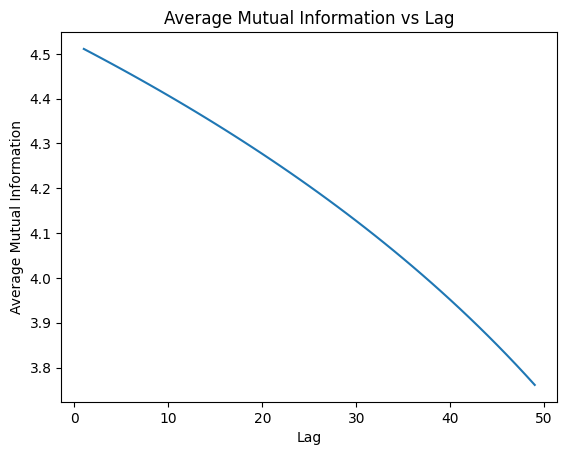

Optimal time delay (tau): 49


In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Function to calculate average mutual information
def average_mutual_information(x, lag, bins=30):
    from sklearn.metrics import mutual_info_score

    # Creating shifted data
    x_shifted = np.roll(x, -lag)
    x_shifted = x_shifted[:-lag]  # Align lengths

    # Calculate mutual information
    mi = mutual_info_score(x[:-lag], x_shifted)
    return mi

# Calculate AMI for different lags
lags = range(1, 50)
ami_values = [average_mutual_information(df['imbalance_price'].values, lag) for lag in lags]

# Plot AMI values
plt.plot(lags, ami_values)
plt.xlabel('Lag')
plt.ylabel('Average Mutual Information')
plt.title('Average Mutual Information vs Lag')
plt.show()

# Select tau as the lag with the first minimum AMI
tau = lags[np.argmin(ami_values)]
print(f"Optimal time delay (tau): {tau}")



In [13]:
from sklearn.neighbors import NearestNeighbors

def false_nearest_neighbors(x, tau, max_dim):
    N = len(x)
    fnn = []
    
    for d in range(1, max_dim + 1):
        X = np.array([x[i: N - (d - 1) * tau] for i in range(d * tau)]).T
        
        # Ensure proper shape
        if X.shape[0] < X.shape[1]:
            continue
        
        nn = NearestNeighbors(n_neighbors=2)
        nn.fit(X)
        distances, indices = nn.kneighbors(X)
        
        R = np.sqrt(np.sum((X - X[indices[:, 1]]) ** 2, axis=1))
        R_next = np.sqrt(np.sum((X - np.roll(X[indices[:, 1]], -tau, axis=0)) ** 2, axis=1))
        
        fnn.append(np.sum(R_next / R > 10) / len(R))
    
    return fnn

# Calculate FNN for different embedding dimensions
max_dim = 10
fnn_values = false_nearest_neighbors(df['imbalance_price'].values, tau, max_dim)

# Plot FNN values
plt.plot(range(1, max_dim + 1), fnn_values)
plt.xlabel('Embedding Dimension')
plt.ylabel('False Nearest Neighbors (%)')
plt.title('False Nearest Neighbors vs Embedding Dimension')
plt.show()

# Select the embedding dimension as the first dimension with near-zero FNN
embedding_dimension = np.where(np.array(fnn_values) < 0.01)[0][0] + 1
print(f"Optimal embedding dimension: {embedding_dimension}")



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (49,) + inhomogeneous part.

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def create_delay_embedding(df, column_name, tau, d):
    n = len(df)
    embedded_data = np.zeros((n - (d - 1) * tau, d))
    
    for i in range(d):
        embedded_data[:, i] = df[column_name].iloc[i * tau : n - (d - 1) * tau + i * tau].values
    
    return pd.DataFrame(embedded_data)

# Create the delay embedding
embedded_df = create_delay_embedding(df, 'imbalance_price', tau, embedding_dimension)

# Plot the reconstructed phase space (if 3D)
if embedding_dimension == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(embedded_df[0], embedded_df[1], embedded_df[2])
    ax.set_xlabel('X(t)')
    ax.set_ylabel(f'X(t+{tau})')
    ax.set_zlabel(f'X(t+{2*tau})')
    plt.title('3D Phase Space Reconstruction')
    plt.show()


NameError: name 'embedding_dimension' is not defined